In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import shutil
from shutil import copyfile
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
import matplotlib.pyplot as plt

In [ ]:
!pip install onedrivedownloader

Download the miniImageNet and EuroSet(RGB) dataset.

In [ ]:
from onedrivedownloader import download
import gdown
# download mini-ImageNet
url = 'https://drive.usercontent.google.com/uc?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&export=download'
output = 'train.tar'
gdown.download(url, output, quiet=False)
# download EuroSAT_RGB
link2 = 'https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1'
if not os.path.exists('./EuroSAT_RGB'):
    print('Downloading EuroSAT_RGB')
    download(link2, filename='./EuroSAT_RGB.zip', unzip=True, unzip_path='./data_final')

Downloading...
From: https://drive.usercontent.google.com/uc?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&export=download
To: /content/train.tar
100%|██████████| 2.42k/2.42k [00:00<00:00, 4.88MB/s]


100%|██████████| 94.7M/94.7M [00:07<00:00, 13.5MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 27011/27011 [00:08<00:00, 3187.81it/s]


Connect google drive to google notebook, in order to save the checkpoint later.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Uncompress train.tar into imagenet directory, and split the data in imagenet as train, val, and test dataset at the ratio of 7:2:1

In [ ]:
class MiniImageNetGenerator(object):
    def __init__(self, tar_dir):
        self.tar_dir = tar_dir
        if self.tar_dir is not None:
            print('Untarring train.rar package')
            self.imagenet_dir = './imagenet'
            if not os.path.exists(self.imagenet_dir):
                os.mkdir(self.imagenet_dir)
            # the directory for train, val and test data
            self.processed_img_dir_train = './train'
            self.processed_img_dir_test = './test'
            self.processed_img_dir_val = './val'
            if not os.path.exists(self.processed_img_dir_train):
                os.mkdir(self.processed_img_dir_train)
            if not os.path.exists(self.processed_img_dir_test):
                os.mkdir(self.processed_img_dir_test)
            if not os.path.exists(self.processed_img_dir_val):
                os.mkdir(self.processed_img_dir_val)
            os.system('tar xvf ' + str(self.tar_dir) + ' -C ' + self.imagenet_dir)
        else:
            print('You need to specify the train.rar source file path')

    def process_original_files(self):
        train_set = []
        val_set = []
        test_set = []
        root_path = '/content/imagenet/train'

        lst = os.listdir(root_path) # your directory path
        # print(lst)
        for item in lst:
            dir_path = os.path.join(root_path, item)
            # print('dir_path:', dir_path)
            all_files = os.listdir(dir_path)
            all_files.sort()

            total_nums = len(all_files)
            train_nums = int(total_nums * 0.7)
            val_nums = int(total_nums * 0.2)
            test_nums = int(total_nums * 0.1)
            train_set = all_files[:train_nums]
            train_path = os.path.join(self.processed_img_dir_train, item)

            if not os.path.exists(train_path):
                os.mkdir(train_path)
            for idx in np.arange(len(train_set)):
                copyfile(os.path.join(dir_path, train_set[idx]),os.path.join(train_path, train_set[idx]))

            val_set = all_files[train_nums:train_nums+val_nums]
            val_path = os.path.join(self.processed_img_dir_val, item)

            if not os.path.exists(val_path):
                os.mkdir(val_path)
            for idx in np.arange(len(val_set)):
                copyfile(os.path.join(dir_path, val_set[idx]),os.path.join(val_path, val_set[idx]))

            test_set = all_files[total_nums-test_nums:]
            test_path = os.path.join(self.processed_img_dir_test, item)

            if not os.path.exists(test_path):
                os.mkdir(test_path)
            for i in np.arange(len(test_set)):
                copyfile(os.path.join(dir_path, test_set[i]),os.path.join(test_path, test_set[i]))

In [ ]:
dataset_generator = MiniImageNetGenerator('./train.tar')
dataset_generator.process_original_files()
print('Untarring finished')

Untarring train.rar package
Untarring finished


Pretrain the ResNet-18 model base on mini-ImageNet dataset

In [ ]:
# Data augmentation and normalization for training
mean = [0.485, 0.456, 0.406]
std =  [0.229, 0.224, 0.225]
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        # Data augmentation, use the simplest random, left-right flipping
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
print('class_names:', len(class_names))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model_params_path = ''

class_names: 64


In [ ]:
!pip install torch-lr-finder

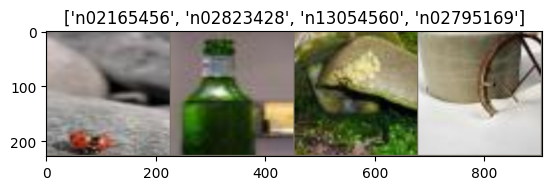

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
import matplotlib.pyplot as plt
# Training the model, including scheduling the learning rate and saving the best model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    model_save_name = 'resnet_1.pt'
    path = F"/content/drive/MyDrive/{model_save_name}"
    print('best_model_params_path:', path)
    best_acc = 0.0

    train_acc = []
    test_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training, test, and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'train':
                train_acc.append(epoch_acc.cpu().numpy())
            if phase == 'val':
                val_acc.append(epoch_acc.cpu().numpy())
            if phase == 'test':
                test_acc.append(epoch_acc.cpu().numpy())
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.plot(epochs, test_acc, label='test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Time')
    plt.legend()
    plt.show()
    # load best model weights
    model.load_state_dict(torch.load(path))
    return model

In [ ]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, len(class_names))

# Freeze pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last classification layer (fc) for fine-tuning
model.fc.requires_grad = True

model_conv = model.to(device)

criterion = nn.CrossEntropyLoss()


To find the approperiate learning rate, the learning rate finder is used to get the suggested value.

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.07E-03


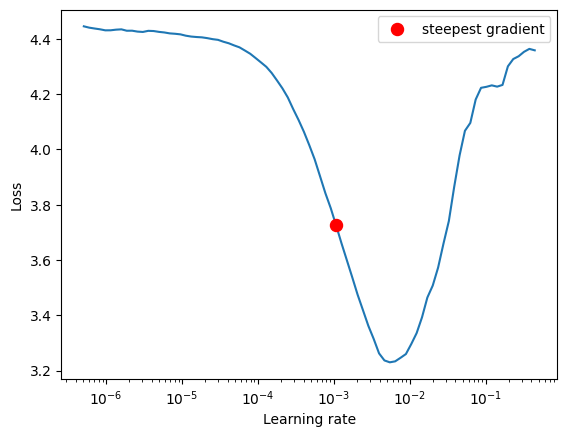

In [ ]:
from torch_lr_finder import LRFinder

optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

# Use the Learning Rate Finder
lr_finder = LRFinder(model, optimizer, criterion=nn.CrossEntropyLoss(), device="cuda")
train_loader = dataloaders['train']
lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")

suggested_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
# print('suggested_lr:', suggested_lr)

# Plot the learning rate finder curve
lr_finder.plot()
lr_finder.reset()

plt.show()

best_model_params_path: /content/drive/MyDrive/resnet_1.pt
Epoch 0/24
----------
train Loss: 2.1082 Acc: 0.4556
val Loss: 1.8103 Acc: 0.5184
test Loss: 1.8978 Acc: 0.5073

Epoch 1/24
----------
train Loss: 1.5993 Acc: 0.5690
val Loss: 1.7206 Acc: 0.5454
test Loss: 1.8091 Acc: 0.5292

Epoch 2/24
----------
train Loss: 1.4197 Acc: 0.6151
val Loss: 1.3626 Acc: 0.6342
test Loss: 1.4883 Acc: 0.6115

Epoch 3/24
----------
train Loss: 1.2920 Acc: 0.6440
val Loss: 1.1678 Acc: 0.6790
test Loss: 1.2588 Acc: 0.6599

Epoch 4/24
----------
train Loss: 1.2102 Acc: 0.6676
val Loss: 1.3174 Acc: 0.6548
test Loss: 1.4158 Acc: 0.6362

Epoch 5/24
----------
train Loss: 1.1443 Acc: 0.6870
val Loss: 1.3893 Acc: 0.6449
test Loss: 1.4607 Acc: 0.6315

Epoch 6/24
----------
train Loss: 1.0738 Acc: 0.7013
val Loss: 1.3175 Acc: 0.6595
test Loss: 1.4550 Acc: 0.6453

Epoch 7/24
----------
train Loss: 0.8507 Acc: 0.7652
val Loss: 0.8156 Acc: 0.7801
test Loss: 0.9174 Acc: 0.7492

Epoch 8/24
----------
train Loss: 0.7

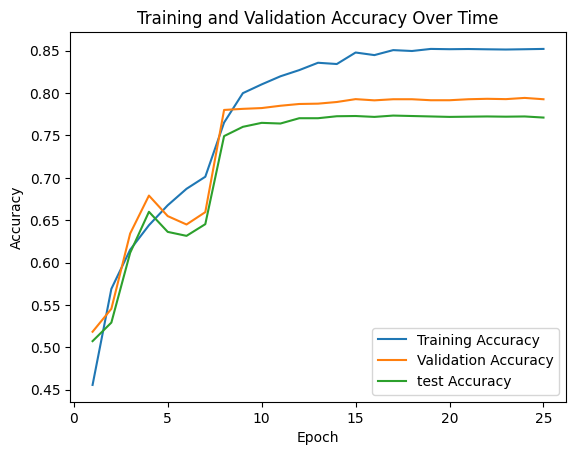

In [ ]:
# train and evaluate
suggested_optimizer = torch.optim.Adam(model.parameters(), lr=1.07E-03)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(suggested_optimizer, step_size=7, gamma=0.1)

# training the last layer for 1 epoch
for epoch in range(1):
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        suggested_optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        suggested_optimizer.step()

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# trains them for the number of epochs requested
pre_trained_model = train_model(model, criterion, suggested_optimizer, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
pre_trained_model.fc

Linear(in_features=512, out_features=64, bias=True)

**Reading the dataset**   

The EuroSAT dataset I use was taken from online images. This dataset based on Sentinel-2 satellite images covering 13 spectral bands and consisting out of 10 classes with in total 27,000 labeled and geo-referenced images. However, I only choose 100 images which are from 5 different categories and each category includes 20 samples. For each category, the first 5 images belong to the train set, and the rest 15 images are in the test set.

In [ ]:
class EuroSATGenerator(object):
  def __init__(self, base_dir, round = 1):
    self.base_dir = base_dir
    if (self.base_dir == None):
      print('please specify the EuroSAT source file path ')
    dir_round = './data_final/' + str(round)
    if not os.path.exists(dir_round):
      os.mkdir(dir_round)
    self.final_dir_train = os.path.join(dir_round, 'train')
    if not os.path.exists(self.final_dir_train):
      os.mkdir(self.final_dir_train)
    self.final_dir_test = os.path.join(dir_round, 'test')
    if not os.path.exists(self.final_dir_test):
      os.mkdir(self.final_dir_test)

  def process_EuroSAT_files(self, num_catagories = 5, num_train=5, num_test = 15):
    lst = os.listdir(self.base_dir)
    # print(lst)
    train_set = []
    test_set = []
    # randomly select 5 catagories
    selected_lst = random.sample(lst, num_catagories)
    # print('selected_lst:', selected_lst)
    for item in selected_lst:
      dir_path = os.path.join(self.base_dir, item)
      all_files = os.listdir(dir_path)
      # print('all_files:', all_files)
      train_set = all_files[:num_train]
      test_set = all_files[num_train: num_train + num_test]
      train_path = os.path.join(self.final_dir_train, item)
      # generate train dataset, The 25 images are from the 5 different categories. Each category includes 5 images
      if not os.path.exists(train_path):
        os.mkdir(train_path)
      for idx in np.arange(len(train_set)):
        copyfile(os.path.join(dir_path, train_set[idx]),os.path.join(train_path, train_set[idx]))
      test_path = os.path.join(self.final_dir_test, item)
      # generate test dataset, The 75 images are from the 5 different categories. Each category includes 15 images
      if not os.path.exists(test_path):
        os.mkdir(test_path)
      for idx in np.arange(len(test_set)):
        copyfile(os.path.join(dir_path, test_set[idx]),os.path.join(test_path, test_set[idx]))


In [ ]:
for i in range (5):
    euro_generator = EuroSATGenerator('/content/data_final/EuroSAT_RGB', i)
    euro_generator.process_EuroSAT_files(num_catagories=5, num_train=5, num_test=15)

I create two instances to read all the image files in the training and testing datasets, respectively.    
      
During training, I first crop a random area of random size and random aspect ratio from the image, and then scale this area to a input image.       
      
During testing, we scale both the height and width of an image to 256 pixels, and then crop a central area as input. In addition, for the three RGB (red, green, and blue) color channels we standardize their values channel by channel. Concretely, the mean value of a channel is subtracted from each value of that channel and then the result is divided by the standard deviation of that channel.

In [ ]:
ft_data_transforms = {
    'train': transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # Add random noise
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
    torchvision.transforms.Resize(256),
    # Crop a 224 x 224 square area from the center of the image
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])
}

I define a training function train_fine_tuning that uses fine-tuning so it can be called multiple times.     
I set the base learning rate to a small value in order to fine-tune the model parameters obtained via pretraining.

In [ ]:
import matplotlib.pyplot as plt
# Training the model, including scheduling the learning rate and saving the best model
def train_fine_tuning(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_acc = 0.0

    train_acc = []
    test_acc = []
    train_loss = []
    test_loss = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training, test, and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in ft_dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / ft_dataset_sizes[phase]
            epoch_acc = running_corrects.double() / ft_dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'train':
                train_acc.append(epoch_acc.cpu().numpy())
                train_loss.append(epoch_loss)
            if phase == 'test':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                test_acc.append(epoch_acc.cpu().numpy())
                test_loss.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, test_acc, label='Testing Accuracy')
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, test_loss, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Time')
    plt.legend()
    plt.show()

    return best_acc

**Defining and Initializing the Model**       
I use ResNet-18, which was pretrained on the mini-ImageNet dataset, as the source model.

In [ ]:
# Create a new ResNet-18 instance
finetune_model = models.resnet18()
finetune_model.fc = nn.Linear(finetune_model.fc.in_features, 64)
# Load the pretrained model
finetune_model.load_state_dict(torch.load('/content/drive/MyDrive/resnet_1.pt'))
finetune_model.fc = nn.Linear(finetune_model.fc.in_features, 5)
finetune_model.eval()  # Set to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.43E-03


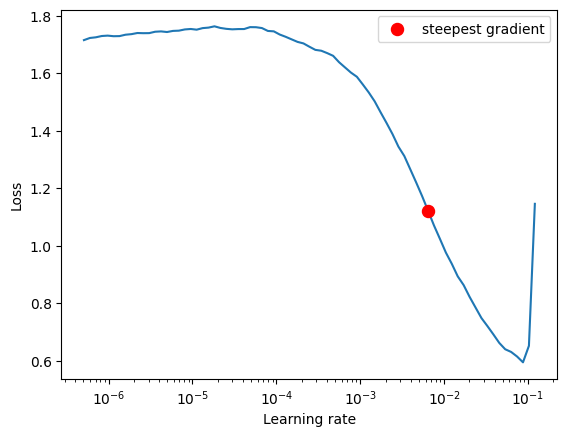

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.06E-03


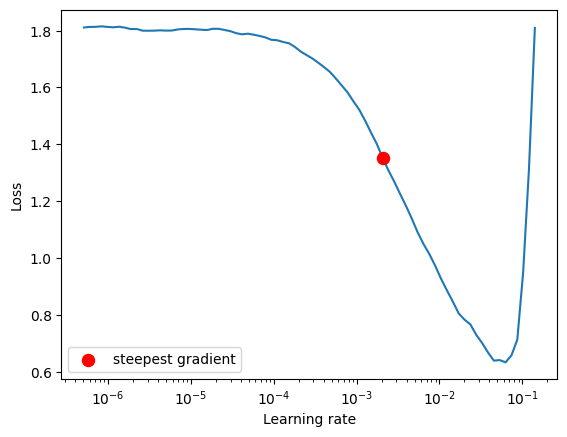

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.94E-03


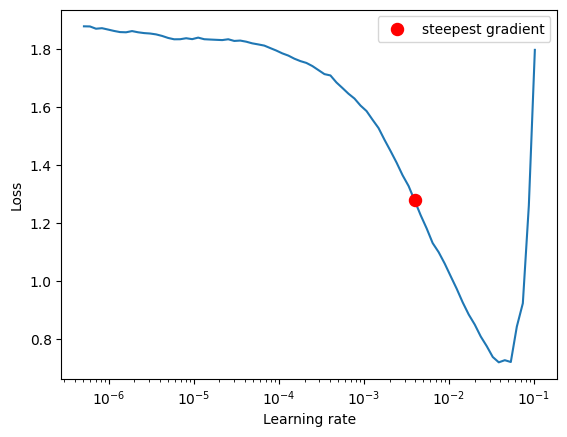

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.35E-03


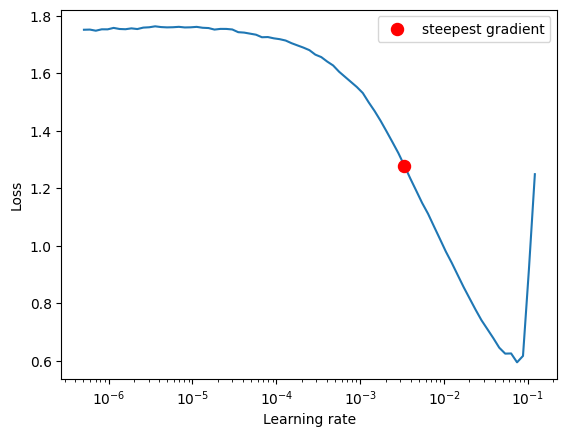

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.64E-03


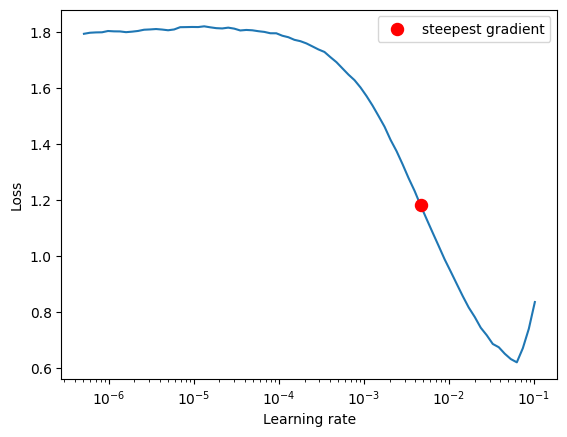

In [ ]:
from torch_lr_finder import LRFinder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer_ft = optim.SGD(finetune_model.parameters(), lr=1e-7, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for i in range(5):
    lr_finder = LRFinder(finetune_model, optimizer_ft, criterion, device)
    data_dir = os.path.join('/content/data_final', str(i))
    EuroSAT_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          ft_data_transforms[x])
                  for x in ['train', 'test']}
    ft_dataloaders = {x: torch.utils.data.DataLoader(EuroSAT_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
    train_loader = ft_dataloaders['train']

    lr_finder.range_test(train_loader, end_lr=1, num_iter=100)

    # Plot the learning rate finder curve
    lr_finder.plot()
    lr_finder.reset()
    plt.show()

Fine-tuning on 5 different sets of 100 EuroSAT images and obtaining their average results.

Epoch 0/24
----------
train Loss: 1.8813 Acc: 0.1200
test Loss: 1.5374 Acc: 0.2933

Epoch 1/24
----------
train Loss: 1.6958 Acc: 0.2400
test Loss: 1.4273 Acc: 0.3733

Epoch 2/24
----------
train Loss: 1.4285 Acc: 0.2800
test Loss: 1.3291 Acc: 0.5200

Epoch 3/24
----------
train Loss: 1.4040 Acc: 0.4400
test Loss: 1.1968 Acc: 0.5733

Epoch 4/24
----------
train Loss: 1.1244 Acc: 0.8000
test Loss: 1.0382 Acc: 0.6533

Epoch 5/24
----------
train Loss: 0.7683 Acc: 0.9200
test Loss: 0.8872 Acc: 0.7333

Epoch 6/24
----------
train Loss: 0.6317 Acc: 0.9200
test Loss: 0.7619 Acc: 0.7600

Epoch 7/24
----------
train Loss: 0.5517 Acc: 0.9200
test Loss: 0.7206 Acc: 0.8000

Epoch 8/24
----------
train Loss: 0.5633 Acc: 0.8400
test Loss: 0.6836 Acc: 0.8133

Epoch 9/24
----------
train Loss: 0.4684 Acc: 0.9200
test Loss: 0.6566 Acc: 0.8267

Epoch 10/24
----------
train Loss: 0.3701 Acc: 1.0000
test Loss: 0.6271 Acc: 0.8267

Epoch 11/24
----------
train Loss: 0.4924 Acc: 0.8800
test Loss: 0.6053 Acc

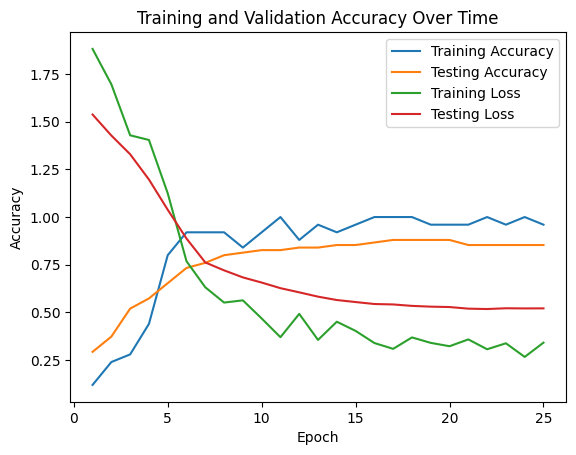

Round 1/5, best accuracy: 0.8800
Epoch 0/24
----------
train Loss: 0.3509 Acc: 0.9600
test Loss: 0.5189 Acc: 0.8400

Epoch 1/24
----------
train Loss: 0.3598 Acc: 0.9600
test Loss: 0.5162 Acc: 0.8400

Epoch 2/24
----------
train Loss: 0.3444 Acc: 0.9600
test Loss: 0.5105 Acc: 0.8533

Epoch 3/24
----------
train Loss: 0.3223 Acc: 0.9600
test Loss: 0.5050 Acc: 0.8400

Epoch 4/24
----------
train Loss: 0.3435 Acc: 1.0000
test Loss: 0.4951 Acc: 0.8400

Epoch 5/24
----------
train Loss: 0.2529 Acc: 0.9600
test Loss: 0.4833 Acc: 0.8533

Epoch 6/24
----------
train Loss: 0.3026 Acc: 0.9600
test Loss: 0.4714 Acc: 0.8533

Epoch 7/24
----------
train Loss: 0.2704 Acc: 1.0000
test Loss: 0.4704 Acc: 0.8533

Epoch 8/24
----------
train Loss: 0.2287 Acc: 1.0000
test Loss: 0.4673 Acc: 0.8533

Epoch 9/24
----------
train Loss: 0.2169 Acc: 1.0000
test Loss: 0.4625 Acc: 0.8533

Epoch 10/24
----------
train Loss: 0.3158 Acc: 0.8800
test Loss: 0.4629 Acc: 0.8533

Epoch 11/24
----------
train Loss: 0.3676 

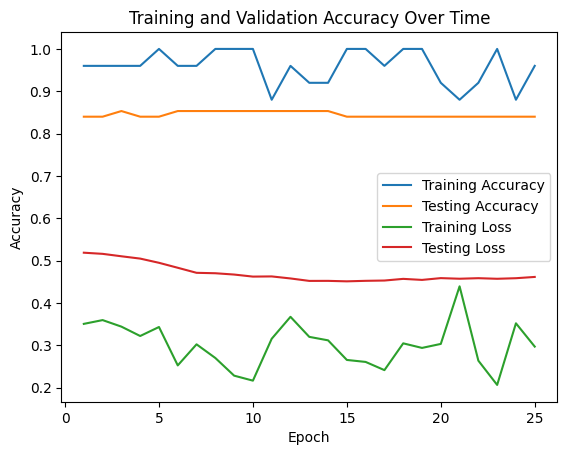

Round 2/5, best accuracy: 0.8533
Epoch 0/24
----------
train Loss: 0.2446 Acc: 1.0000
test Loss: 0.4651 Acc: 0.8400

Epoch 1/24
----------
train Loss: 0.1877 Acc: 1.0000
test Loss: 0.4682 Acc: 0.8400

Epoch 2/24
----------
train Loss: 0.2726 Acc: 1.0000
test Loss: 0.4642 Acc: 0.8267

Epoch 3/24
----------
train Loss: 0.2286 Acc: 1.0000
test Loss: 0.4636 Acc: 0.8267

Epoch 4/24
----------
train Loss: 0.2374 Acc: 0.9200
test Loss: 0.4588 Acc: 0.8267

Epoch 5/24
----------
train Loss: 0.3064 Acc: 0.9600
test Loss: 0.4454 Acc: 0.8533

Epoch 6/24
----------
train Loss: 0.2508 Acc: 1.0000
test Loss: 0.4364 Acc: 0.8533

Epoch 7/24
----------
train Loss: 0.1827 Acc: 1.0000
test Loss: 0.4365 Acc: 0.8533

Epoch 8/24
----------
train Loss: 0.1600 Acc: 1.0000
test Loss: 0.4360 Acc: 0.8533

Epoch 9/24
----------
train Loss: 0.1538 Acc: 1.0000
test Loss: 0.4344 Acc: 0.8533

Epoch 10/24
----------
train Loss: 0.1678 Acc: 0.9600
test Loss: 0.4314 Acc: 0.8533

Epoch 11/24
----------
train Loss: 0.2015 

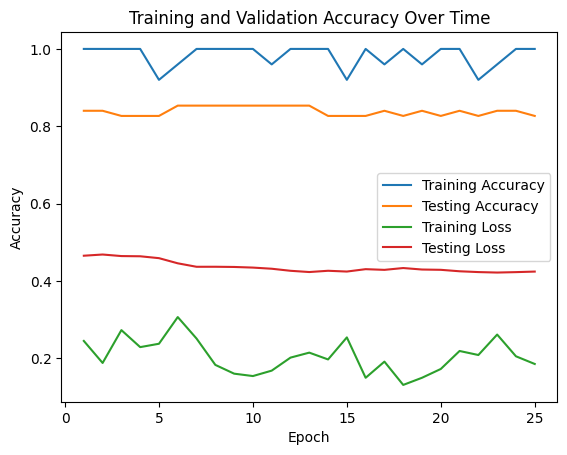

Round 3/5, best accuracy: 0.8533
Epoch 0/24
----------
train Loss: 0.2118 Acc: 0.9600
test Loss: 0.4193 Acc: 0.8133

Epoch 1/24
----------
train Loss: 0.2502 Acc: 0.9600
test Loss: 0.4224 Acc: 0.8267

Epoch 2/24
----------
train Loss: 0.1507 Acc: 1.0000
test Loss: 0.4268 Acc: 0.8267

Epoch 3/24
----------
train Loss: 0.1248 Acc: 1.0000
test Loss: 0.4283 Acc: 0.8400

Epoch 4/24
----------
train Loss: 0.1698 Acc: 1.0000
test Loss: 0.4310 Acc: 0.8400

Epoch 5/24
----------
train Loss: 0.2046 Acc: 0.9200
test Loss: 0.4305 Acc: 0.8400

Epoch 6/24
----------
train Loss: 0.2518 Acc: 0.9600
test Loss: 0.4279 Acc: 0.8400

Epoch 7/24
----------
train Loss: 0.1517 Acc: 1.0000
test Loss: 0.4234 Acc: 0.8533

Epoch 8/24
----------
train Loss: 0.1779 Acc: 1.0000
test Loss: 0.4251 Acc: 0.8400

Epoch 9/24
----------
train Loss: 0.1769 Acc: 1.0000
test Loss: 0.4214 Acc: 0.8267

Epoch 10/24
----------
train Loss: 0.1250 Acc: 1.0000
test Loss: 0.4193 Acc: 0.8267

Epoch 11/24
----------
train Loss: 0.1581 

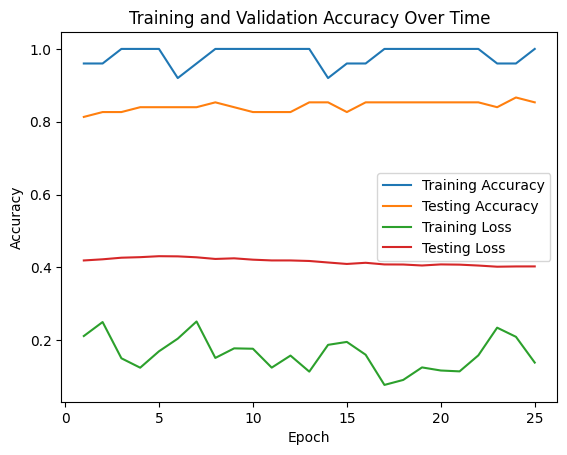

Round 4/5, best accuracy: 0.8667
Epoch 0/24
----------
train Loss: 0.1735 Acc: 1.0000
test Loss: 0.4052 Acc: 0.8400

Epoch 1/24
----------
train Loss: 0.1754 Acc: 0.9600
test Loss: 0.4064 Acc: 0.8533

Epoch 2/24
----------
train Loss: 0.1698 Acc: 0.9600
test Loss: 0.4082 Acc: 0.8533

Epoch 3/24
----------
train Loss: 0.1461 Acc: 1.0000
test Loss: 0.4025 Acc: 0.8400

Epoch 4/24
----------
train Loss: 0.1802 Acc: 0.9600
test Loss: 0.4045 Acc: 0.8400

Epoch 5/24
----------
train Loss: 0.1013 Acc: 1.0000
test Loss: 0.4114 Acc: 0.8400

Epoch 6/24
----------
train Loss: 0.1412 Acc: 1.0000
test Loss: 0.4062 Acc: 0.8400

Epoch 7/24
----------
train Loss: 0.2678 Acc: 0.9600
test Loss: 0.3958 Acc: 0.8400

Epoch 8/24
----------
train Loss: 0.0957 Acc: 1.0000
test Loss: 0.3918 Acc: 0.8267

Epoch 9/24
----------
train Loss: 0.1118 Acc: 1.0000
test Loss: 0.3861 Acc: 0.8400

Epoch 10/24
----------
train Loss: 0.0973 Acc: 1.0000
test Loss: 0.3792 Acc: 0.8400

Epoch 11/24
----------
train Loss: 0.2223 

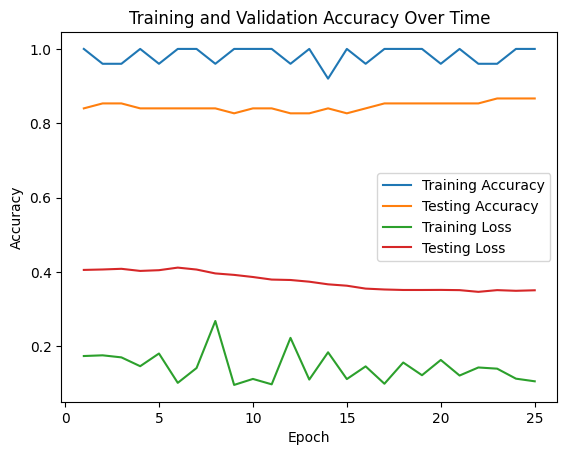

Round 5/5, best accuracy: 0.8667
after 5 round training, avg_acc: 0.8640


In [ ]:
round = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
total = 0.0
euro_suggested_lr = [6.43e-03, 2.06e-03, 3.94e-03, 3.35e-03, 4.64E-03]
for i in range(round):
    ft_dataset_sizes = {x: len(EuroSAT_datasets[x]) for x in ['train', 'test']}
    ft_class_names = EuroSAT_datasets['train'].classes
    # Freeze all pre-trained layers
    for param in finetune_model.parameters():
        param.requires_grad = False

    # Unfreeze the randomly added layers
    for name, param in finetune_model.fc.named_parameters():
        param.requires_grad = True
    finetune_model = finetune_model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(finetune_model.parameters(), lr= euro_suggested_lr[i], momentum=0.9)

    # Decay LR by a factor of 0.1 every 5 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.2)
    best_acc = train_fine_tuning(finetune_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
    print(f'Round {i+1}/{round}, best accuracy: {best_acc:.4f}')
    total += best_acc
avg_acc = total / round
print(f'after {round} round training, avg_acc: {avg_acc:.4f}')

Use the CUB dataset as a comprison. The procedure is the same the EuroSAT's.

In [ ]:
from onedrivedownloader import download

link='https://github.com/cyizhuo/CUB-200-2011-dataset/archive/refs/heads/main.zip'
if not os.path.exists('./CUB'):
    print('Downloading CUB')
    download(link, filename='./CUB.zip', unzip=True, unzip_path='./')

Unzipping file...


Extracting files: 100%|██████████| 12192/12192 [00:12<00:00, 977.49it/s] 


In [ ]:
class CUBGenerator(object):
  def __init__(self, base_dir, round = 1):
    self.base_dir = base_dir
    if (self.base_dir == None):
      print('please specify the EuroSAT source file path ')
    dir_round = base_dir + str(round)
    if not os.path.exists(dir_round):
      os.mkdir(dir_round)
    self.final_dir_train = os.path.join(dir_round, 'train')
    if not os.path.exists(self.final_dir_train):
      os.mkdir(self.final_dir_train)
    self.final_dir_test = os.path.join(dir_round, 'test')
    if not os.path.exists(self.final_dir_test):
      os.mkdir(self.final_dir_test)

  def process_CUB_files(self, num_catagories = 5, num_train=5, num_test = 15):
    path = os.path.join(self.base_dir,'train')
    lst = os.listdir(path)
    # print(lst)
    train_set = []
    test_set = []
    # randomly select 5 catagories
    selected_lst = random.sample(lst, num_catagories)
    print('selected_lst:', selected_lst)
    for item in selected_lst:
      dir_path = os.path.join(path, item)
      all_files = os.listdir(dir_path)
      # print('all_files:', all_files)
      train_set = all_files[:num_train]
      test_set = all_files[num_train: num_train + num_test]
      train_path = os.path.join(self.final_dir_train, item)
      # generate train dataset, The 25 images are from the 5 different categories. Each category includes 5 images
      if not os.path.exists(train_path):
        os.mkdir(train_path)
      for idx in np.arange(len(train_set)):
        copyfile(os.path.join(dir_path, train_set[idx]),os.path.join(train_path, train_set[idx]))
      test_path = os.path.join(self.final_dir_test, item)
      # generate test dataset, The 75 images are from the 5 different categories. Each category includes 15 images
      if not os.path.exists(test_path):
        os.mkdir(test_path)
      for idx in np.arange(len(test_set)):
        copyfile(os.path.join(dir_path, test_set[idx]),os.path.join(test_path, test_set[idx]))


In [ ]:
for i in range (5):
    euro_generator = CUBGenerator('/content/CUB-200-2011-dataset-main', i)
    euro_generator.process_CUB_files(num_catagories=5, num_train=5, num_test=15)

selected_lst: ['010.Red_winged_Blackbird', '144.Common_Tern', '136.Barn_Swallow', '003.Sooty_Albatross', '034.Gray_crowned_Rosy_Finch']
selected_lst: ['071.Long_tailed_Jaeger', '063.Ivory_Gull', '181.Worm_eating_Warbler', '032.Mangrove_Cuckoo', '020.Yellow_breasted_Chat']
selected_lst: ['007.Parakeet_Auklet', '023.Brandt_Cormorant', '097.Orchard_Oriole', '153.Philadelphia_Vireo', '112.Great_Grey_Shrike']
selected_lst: ['092.Nighthawk', '082.Ringed_Kingfisher', '111.Loggerhead_Shrike', '074.Florida_Jay', '004.Groove_billed_Ani']
selected_lst: ['195.Carolina_Wren', '159.Black_and_white_Warbler', '057.Rose_breasted_Grosbeak', '089.Hooded_Merganser', '037.Acadian_Flycatcher']


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-02


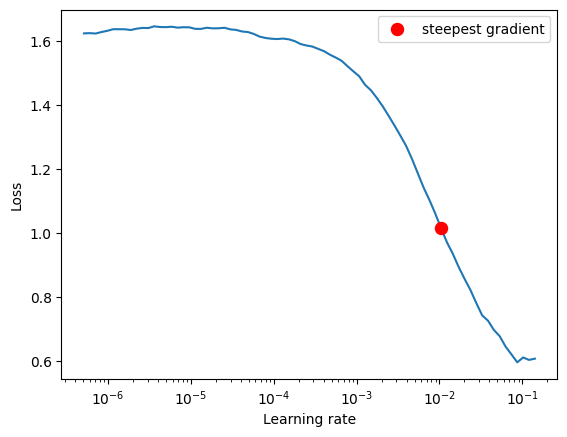

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.94E-03


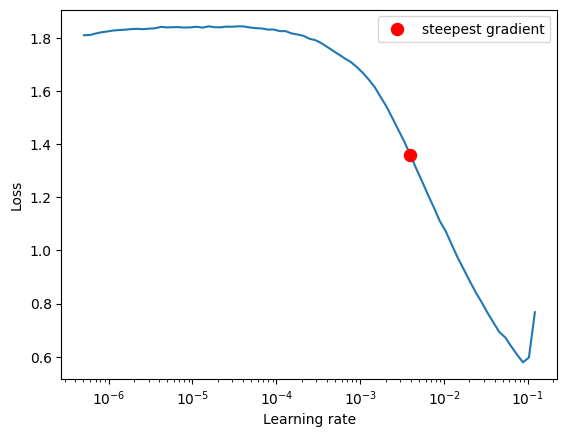

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.90E-03


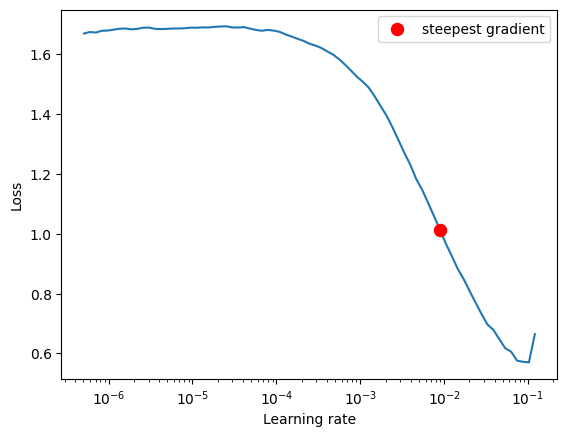

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.46E-03


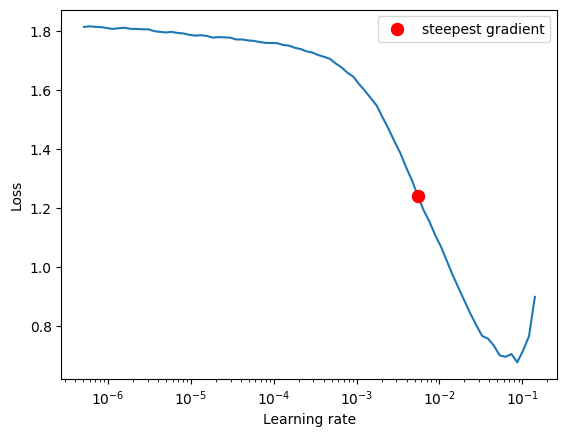

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.56E-03


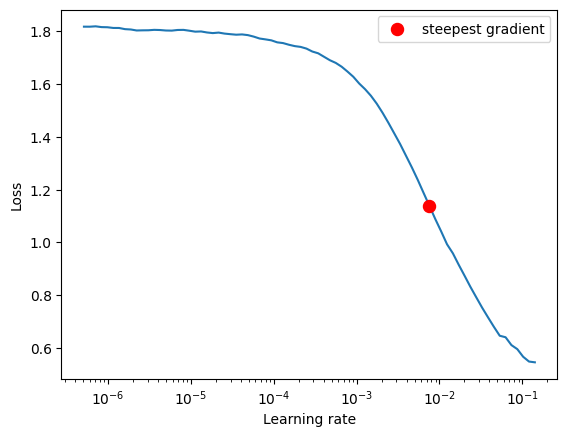

In [ ]:
from torch_lr_finder import LRFinder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer_ft_cub = optim.SGD(finetune_model.parameters(), lr=1e-7, momentum=0.9)
criterion_cub = nn.CrossEntropyLoss()

for i in range(5):
    lr_finder = LRFinder(finetune_model, optimizer_ft_cub, criterion_cub, device)
    data_dir = '/content/CUB-200-2011-dataset-main' + str(i)

    CUB_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          ft_data_transforms[x])
                  for x in ['train', 'test']}
    ft_dataloaders = {x: torch.utils.data.DataLoader(CUB_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
    train_loader = ft_dataloaders['train']

    lr_finder.range_test(train_loader, end_lr=1, num_iter=100)

    # Plot the learning rate finder curve
    lr_finder.plot()
    lr_finder.reset()
    plt.show()

data_dir: /content/CUB-200-2011-dataset-main0
Epoch 0/24
----------
train Loss: 1.6575 Acc: 0.2400
test Loss: 1.5939 Acc: 0.3200

Epoch 1/24
----------
train Loss: 1.5610 Acc: 0.3200
test Loss: 1.5331 Acc: 0.3600

Epoch 2/24
----------
train Loss: 1.5269 Acc: 0.4000
test Loss: 1.4235 Acc: 0.3867

Epoch 3/24
----------
train Loss: 1.2149 Acc: 0.5200
test Loss: 1.2508 Acc: 0.5067

Epoch 4/24
----------
train Loss: 1.0967 Acc: 0.7600
test Loss: 1.1403 Acc: 0.5467

Epoch 5/24
----------
train Loss: 0.8827 Acc: 0.8400
test Loss: 1.0463 Acc: 0.5867

Epoch 6/24
----------
train Loss: 0.8143 Acc: 0.8000
test Loss: 0.9602 Acc: 0.6533

Epoch 7/24
----------
train Loss: 0.5673 Acc: 0.8800
test Loss: 0.9423 Acc: 0.6667

Epoch 8/24
----------
train Loss: 0.7001 Acc: 0.8000
test Loss: 0.9344 Acc: 0.6667

Epoch 9/24
----------
train Loss: 0.5654 Acc: 0.9200
test Loss: 0.9317 Acc: 0.6667

Epoch 10/24
----------
train Loss: 0.5038 Acc: 0.9200
test Loss: 0.9339 Acc: 0.6667

Epoch 11/24
----------
train 

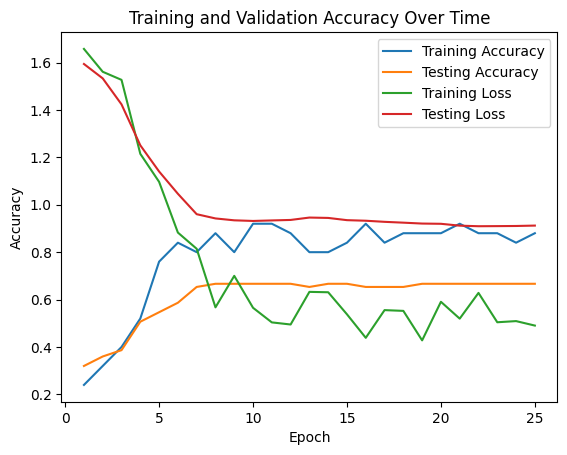

Round 1/5, best accuracy: 0.6667
data_dir: /content/CUB-200-2011-dataset-main1
Epoch 0/24
----------
train Loss: 2.4544 Acc: 0.0400
test Loss: 2.2441 Acc: 0.1600

Epoch 1/24
----------
train Loss: 2.2067 Acc: 0.0400
test Loss: 2.1739 Acc: 0.1467

Epoch 2/24
----------
train Loss: 2.3134 Acc: 0.1200
test Loss: 2.0771 Acc: 0.1733

Epoch 3/24
----------
train Loss: 2.0081 Acc: 0.0800
test Loss: 1.9558 Acc: 0.1733

Epoch 4/24
----------
train Loss: 1.5712 Acc: 0.2800
test Loss: 1.8246 Acc: 0.2000

Epoch 5/24
----------
train Loss: 1.7649 Acc: 0.2000
test Loss: 1.6911 Acc: 0.2533

Epoch 6/24
----------
train Loss: 1.4836 Acc: 0.3200
test Loss: 1.5501 Acc: 0.3200

Epoch 7/24
----------
train Loss: 1.1266 Acc: 0.5200
test Loss: 1.5262 Acc: 0.3733

Epoch 8/24
----------
train Loss: 1.0316 Acc: 0.6000
test Loss: 1.5070 Acc: 0.3733

Epoch 9/24
----------
train Loss: 1.1941 Acc: 0.5600
test Loss: 1.4775 Acc: 0.4133

Epoch 10/24
----------
train Loss: 1.0837 Acc: 0.4800
test Loss: 1.4522 Acc: 0.44

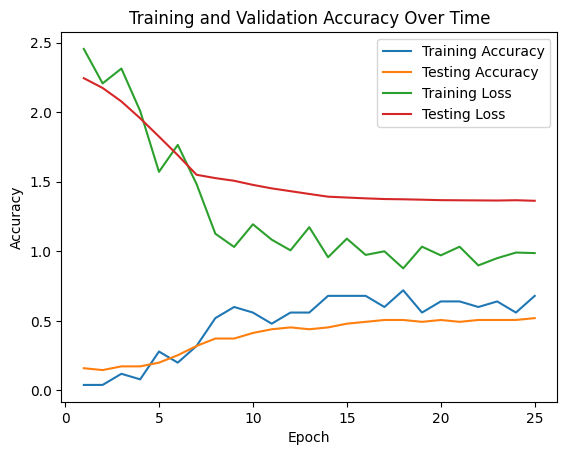

Round 2/5, best accuracy: 0.5200
data_dir: /content/CUB-200-2011-dataset-main2
Epoch 0/24
----------
train Loss: 2.0562 Acc: 0.2000
test Loss: 1.7470 Acc: 0.2133

Epoch 1/24
----------
train Loss: 1.8100 Acc: 0.2400
test Loss: 1.6115 Acc: 0.2667

Epoch 2/24
----------
train Loss: 1.7032 Acc: 0.4000
test Loss: 1.4374 Acc: 0.3467

Epoch 3/24
----------
train Loss: 1.5605 Acc: 0.4800
test Loss: 1.2496 Acc: 0.4800

Epoch 4/24
----------
train Loss: 1.1624 Acc: 0.5600
test Loss: 1.0622 Acc: 0.5867

Epoch 5/24
----------
train Loss: 0.9817 Acc: 0.6000
test Loss: 0.9181 Acc: 0.6800

Epoch 6/24
----------
train Loss: 0.7322 Acc: 0.7600
test Loss: 0.8024 Acc: 0.7467

Epoch 7/24
----------
train Loss: 0.5424 Acc: 0.8400
test Loss: 0.7829 Acc: 0.7733

Epoch 8/24
----------
train Loss: 0.5379 Acc: 0.8800
test Loss: 0.7623 Acc: 0.7600

Epoch 9/24
----------
train Loss: 0.6344 Acc: 0.8000
test Loss: 0.7442 Acc: 0.7600

Epoch 10/24
----------
train Loss: 0.4065 Acc: 0.8800
test Loss: 0.7308 Acc: 0.76

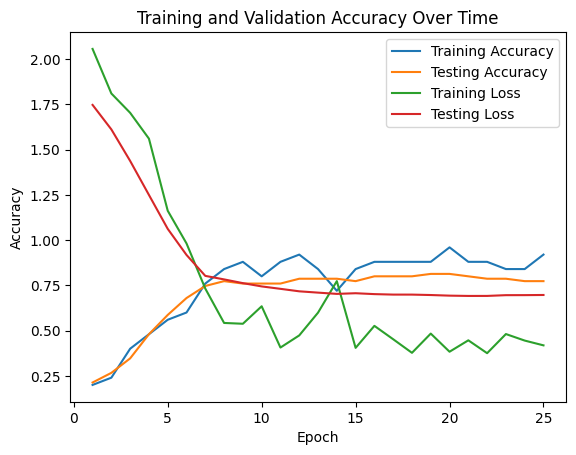

Round 3/5, best accuracy: 0.8133
data_dir: /content/CUB-200-2011-dataset-main3
Epoch 0/24
----------
train Loss: 2.0665 Acc: 0.2800
test Loss: 1.8949 Acc: 0.2400

Epoch 1/24
----------
train Loss: 1.8615 Acc: 0.2800
test Loss: 1.8579 Acc: 0.3067

Epoch 2/24
----------
train Loss: 1.7679 Acc: 0.3200
test Loss: 1.8320 Acc: 0.3467

Epoch 3/24
----------
train Loss: 1.7989 Acc: 0.2800
test Loss: 1.7896 Acc: 0.3600

Epoch 4/24
----------
train Loss: 1.3978 Acc: 0.3600
test Loss: 1.6989 Acc: 0.3733

Epoch 5/24
----------
train Loss: 1.5163 Acc: 0.3200
test Loss: 1.5834 Acc: 0.3867

Epoch 6/24
----------
train Loss: 1.2744 Acc: 0.5200
test Loss: 1.4804 Acc: 0.3733

Epoch 7/24
----------
train Loss: 1.2165 Acc: 0.5200
test Loss: 1.4662 Acc: 0.3867

Epoch 8/24
----------
train Loss: 1.0555 Acc: 0.6800
test Loss: 1.4452 Acc: 0.3867

Epoch 9/24
----------
train Loss: 1.1198 Acc: 0.6400
test Loss: 1.4268 Acc: 0.4000

Epoch 10/24
----------
train Loss: 0.9295 Acc: 0.5200
test Loss: 1.4130 Acc: 0.40

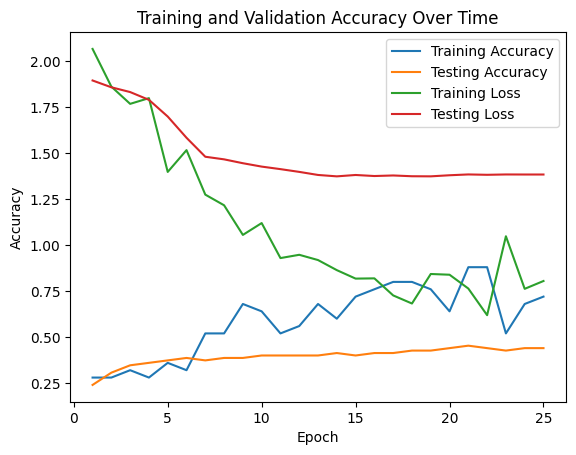

Round 4/5, best accuracy: 0.4533
data_dir: /content/CUB-200-2011-dataset-main4
Epoch 0/24
----------
train Loss: 2.4331 Acc: 0.1600
test Loss: 2.2203 Acc: 0.1600

Epoch 1/24
----------
train Loss: 2.0944 Acc: 0.0800
test Loss: 2.1481 Acc: 0.2000

Epoch 2/24
----------
train Loss: 1.9607 Acc: 0.2400
test Loss: 2.0400 Acc: 0.2267

Epoch 3/24
----------
train Loss: 1.9402 Acc: 0.2800
test Loss: 1.8641 Acc: 0.2667

Epoch 4/24
----------
train Loss: 1.7622 Acc: 0.4000
test Loss: 1.6518 Acc: 0.2800

Epoch 5/24
----------
train Loss: 1.3896 Acc: 0.5600
test Loss: 1.4232 Acc: 0.4133

Epoch 6/24
----------
train Loss: 1.1163 Acc: 0.5600
test Loss: 1.2743 Acc: 0.5067

Epoch 7/24
----------
train Loss: 0.9179 Acc: 0.6800
test Loss: 1.2621 Acc: 0.5200

Epoch 8/24
----------
train Loss: 0.9690 Acc: 0.6400
test Loss: 1.2472 Acc: 0.5200

Epoch 9/24
----------
train Loss: 0.9994 Acc: 0.6000
test Loss: 1.2293 Acc: 0.5067

Epoch 10/24
----------
train Loss: 0.7443 Acc: 0.7600
test Loss: 1.2116 Acc: 0.50

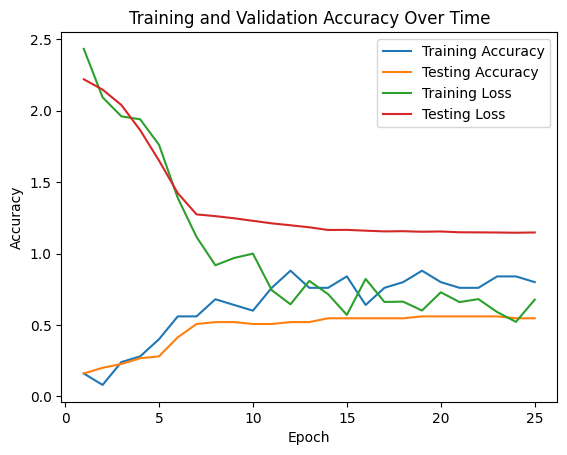

Round 5/5, best accuracy: 0.5600
after 5 round training, avg_acc: 0.6027


In [ ]:
round = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
total = 0.0
suggested_lr = [1.05E-02, 3.94E-03, 8.90E-03, 5.46E-03, 7.56E-03]
for i in range(round):
    data_dir = '/content/CUB-200-2011-dataset-main'+str(i)
    print('data_dir:', data_dir)
    CUB_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          ft_data_transforms[x])
                  for x in ['train', 'test']}
    ft_dataloaders = {x: torch.utils.data.DataLoader(CUB_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
    ft_dataset_sizes = {x: len(CUB_datasets[x]) for x in ['train', 'test']}
    ft_class_names = CUB_datasets['train'].classes

    # Freeze all pre-trained layers
    for param in finetune_model.parameters():
        param.requires_grad = False

    # Unfreeze the randomly added layers
    for name, param in finetune_model.fc.named_parameters():
        param.requires_grad = True

    finetune_model = finetune_model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(finetune_model.parameters(), lr=suggested_lr[i], momentum=0.9)

    # Decay LR by a factor of 0.2 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.2)
    best_acc = train_fine_tuning(finetune_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
    print(f'Round {i+1}/{round}, best accuracy: {best_acc:.4f}')
    total += best_acc
avg_acc = total / round
print(f'after {round} round training, avg_acc: {avg_acc:.4f}')